In [ ]:
!pip install torch_geometric --user 
!pip install torch_sparse --user 
!pip install torch_scatter --user 
!pip install pytorch_lightning --user 

In [1]:
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_undirected, is_undirected, convert
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
#from torch_geometric.nn import GCNConv
import torch.nn.functional as F

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))  

In [2]:
cities_df = pd.DataFrame({
    'city':['bangalore','Mumbai','Delhi','kolkatta','chennai','bhopal'],
    'lat':[12.9716,19.076,28.7041,22.5726,13.0827,23.2599],
    'lon':[77.5946,72.877,77.1025,88.639,80.2707,77.4126],
    'x1':[20,35,24,33,35,18],
    'x2':[5,5,7,13,16,21],
    'y':[1200,1500,2000,1780,1450,3000]})
cities_df

,city,lat,lon,x1,x2,y
0,bangalore,12.9716,77.5946,20,5,1200
1,Mumbai,19.0760,72.8770,35,5,1500
2,Delhi,28.7041,77.1025,24,7,2000
3,kolkatta,22.5726,88.6390,33,13,1780
4,chennai,13.0827,80.2707,35,16,1450
5,bhopal,23.2599,77.4126,18,21,3000


In [3]:
cities_df['lat'] = np.radians(cities_df['lat'])
cities_df['lon'] = np.radians(cities_df['lon'])

In [4]:
dist = DistanceMetric.get_metric('haversine')

In [5]:
cities_df[['lat','lon']].to_numpy()

array([[0.22639713, 1.35428125],
       [0.33293901, 1.2719436 ],
       [0.50098105, 1.34569249],
       [0.39396619, 1.5470424 ],
       [0.22833619, 1.40098801],
       [0.40596184, 1.35110475]])

In [6]:
df_dist_matrix = pd.DataFrame(dist.pairwise(cities_df[['lat','lon']].to_numpy())*6373,  columns=cities_df.city, index=cities_df.city)

,bangalore,Mumbai,Delhi,kolkatta,chennai,bhopal
bangalore,0.000000,845.628325,1750.664163,1582.525176,290.263116,1144.527052
Mumbai,845.628325,0.000000,1153.629733,1683.203283,1033.479952,661.621084
Delhi,1750.664163,1153.629733,0.000000,1341.809060,1768.206317,606.349722
kolkatta,1582.525176,1683.203283,1341.809060,0.000000,1377.283504,1152.404181
chennai,290.263116,1033.479952,1768.206317,1377.283504,0.000000,1171.476936
bhopal,1144.527052,661.621084,606.349722,1152.404181,1171.476936,0.000000


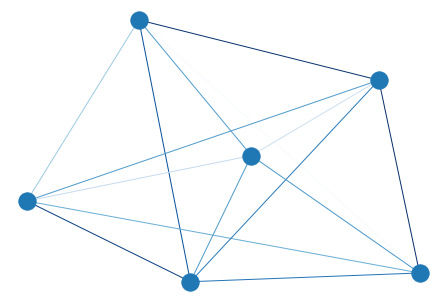

In [7]:
G = nx.from_numpy_matrix(df_dist_matrix.values)
nx.draw(G, edge_color = [i[2]['weight'] for i in G.edges(data=True)], edge_cmap = plt.cm.Blues)

In [8]:
D = df_dist_matrix.values

In [9]:
D[D <1200] = 1
D[D >=1200] = 0

In [10]:
D

array([[1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

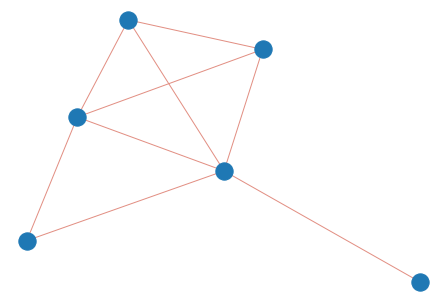

In [11]:
G = nx.from_numpy_matrix(D)
nx.draw(G, edge_color = '#E28F83')

In [12]:
a = torch.tensor([[1.4335,-1.0990,-0.8586],[2.1553,2.2728,-0.8020],[1.0524,0.1599,-0.0374]])

In [13]:
a

tensor([[ 1.4335, -1.0990, -0.8586],
        [ 2.1553,  2.2728, -0.8020],
        [ 1.0524,  0.1599, -0.0374]])

In [14]:
a = torch.tensor([[0.9041,0.0196],[-0.3108,-2.4423],[-0.4821,1.059]])
b = torch.tensor([[-2.1763,-0.4713],[-0.6986,1.3702]])
torch.cdist(a, b, p=2)

tensor([[3.1193, 2.0959],
        [2.7138, 3.8322],
        [2.2830, 0.3791]])

In [15]:
x = torch.tensor([[2,1],[5,6],[3,7],[12,0]], dtype=torch.float)
y = torch.tensor([0,1,0,1], dtype=torch.float)

In [16]:
edge_index = from_networkx(G).edge_index
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
        [0, 1, 4, 5, 0, 1, 2, 4, 5, 1, 2, 5, 3, 5, 0, 1, 4, 5, 0, 1, 2, 3, 4, 5]])

In [17]:
x = torch.tensor(cities_df[['x1','x2']].values, dtype=torch.float)
x

tensor([[20.,  5.],
        [35.,  5.],
        [24.,  7.],
        [33., 13.],
        [35., 16.],
        [18., 21.]])

In [18]:
y = torch.tensor(cities_df[['y']].values, dtype=torch.float)
y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])

In [19]:
y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])

In [20]:
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
        [0, 1, 4, 5, 0, 1, 2, 4, 5, 1, 2, 5, 3, 5, 0, 1, 4, 5, 0, 1, 2, 3, 4, 5]])

In [21]:
data = Data(x=x, y=y, edge_index=edge_index)

In [22]:
data

Data(edge_index=[2, 24], x=[6, 2], y=[6, 1])

In [23]:
from torch.utils.data import DataLoader
loader = DataLoader(data, batch_size=512, shuffle=True)

In [24]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [25]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 2)
        self.conv2 = GCNConv(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(data).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [27]:
num_epochs = 1000000

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = MAPELoss(out, data.y)
    loss.backward()
    optimizer.step()
    # Print the progress
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [100/1000000], Loss: 0.9927
Epoch [200/1000000], Loss: 0.9922
Epoch [300/1000000], Loss: 0.9930
Epoch [400/1000000], Loss: 0.9962
Epoch [500/1000000], Loss: 0.9853
Epoch [600/1000000], Loss: 0.9852
Epoch [700/1000000], Loss: 0.9562
Epoch [800/1000000], Loss: 0.9432
Epoch [900/1000000], Loss: 0.9485
Epoch [1000/1000000], Loss: 0.9258
Epoch [1100/1000000], Loss: 0.9212
Epoch [1200/1000000], Loss: 0.9635
Epoch [1300/1000000], Loss: 0.9582
Epoch [1400/1000000], Loss: 0.9623
Epoch [1500/1000000], Loss: 0.8929
Epoch [1600/1000000], Loss: 0.8179
Epoch [1700/1000000], Loss: 0.8850
Epoch [1800/1000000], Loss: 0.8733
Epoch [1900/1000000], Loss: 0.9321
Epoch [2000/1000000], Loss: 0.7300
Epoch [2100/1000000], Loss: 0.8872
Epoch [2200/1000000], Loss: 0.9122
Epoch [2300/1000000], Loss: 0.8425
Epoch [2400/1000000], Loss: 0.7366
Epoch [2500/1000000], Loss: 0.8187
Epoch [2600/1000000], Loss: 0.7133
Epoch [2700/1000000], Loss: 0.5032
Epoch [2800/1000000], Loss: 0.8666
Epoch [2900/1000000], Loss: 0

Epoch [23200/1000000], Loss: 0.3895
Epoch [23300/1000000], Loss: 0.2381
Epoch [23400/1000000], Loss: 0.6074
Epoch [23500/1000000], Loss: 0.3637
Epoch [23600/1000000], Loss: 0.2827
Epoch [23700/1000000], Loss: 0.3593
Epoch [23800/1000000], Loss: 0.2686
Epoch [23900/1000000], Loss: 0.2301
Epoch [24000/1000000], Loss: 0.5070
Epoch [24100/1000000], Loss: 0.3812
Epoch [24200/1000000], Loss: 0.3366
Epoch [24300/1000000], Loss: 0.4291
Epoch [24400/1000000], Loss: 0.2708
Epoch [24500/1000000], Loss: 0.3794
Epoch [24600/1000000], Loss: 0.1854
Epoch [24700/1000000], Loss: 0.6630
Epoch [24800/1000000], Loss: 0.6651
Epoch [24900/1000000], Loss: 0.2782
Epoch [25000/1000000], Loss: 0.7522
Epoch [25100/1000000], Loss: 0.3900
Epoch [25200/1000000], Loss: 0.2270
Epoch [25300/1000000], Loss: 0.2978
Epoch [25400/1000000], Loss: 0.4486
Epoch [25500/1000000], Loss: 0.6458
Epoch [25600/1000000], Loss: 0.3363
Epoch [25700/1000000], Loss: 0.3109
Epoch [25800/1000000], Loss: 0.2085
Epoch [25900/1000000], Loss:

Epoch [46000/1000000], Loss: 0.4628
Epoch [46100/1000000], Loss: 0.3936
Epoch [46200/1000000], Loss: 0.4285
Epoch [46300/1000000], Loss: 0.4134
Epoch [46400/1000000], Loss: 0.4944
Epoch [46500/1000000], Loss: 0.2963
Epoch [46600/1000000], Loss: 0.2244
Epoch [46700/1000000], Loss: 0.3208
Epoch [46800/1000000], Loss: 0.4184
Epoch [46900/1000000], Loss: 0.2964
Epoch [47000/1000000], Loss: 0.2572
Epoch [47100/1000000], Loss: 0.3691
Epoch [47200/1000000], Loss: 0.1878
Epoch [47300/1000000], Loss: 0.3490
Epoch [47400/1000000], Loss: 0.3854
Epoch [47500/1000000], Loss: 0.5129
Epoch [47600/1000000], Loss: 0.3283
Epoch [47700/1000000], Loss: 0.2577
Epoch [47800/1000000], Loss: 0.4111
Epoch [47900/1000000], Loss: 0.2249
Epoch [48000/1000000], Loss: 0.5093
Epoch [48100/1000000], Loss: 0.6042
Epoch [48200/1000000], Loss: 0.2646
Epoch [48300/1000000], Loss: 0.4201
Epoch [48400/1000000], Loss: 0.4231
Epoch [48500/1000000], Loss: 0.2859
Epoch [48600/1000000], Loss: 0.1882
Epoch [48700/1000000], Loss:

Epoch [68900/1000000], Loss: 0.3075
Epoch [69000/1000000], Loss: 0.2987
Epoch [69100/1000000], Loss: 0.2116
Epoch [69200/1000000], Loss: 0.1965
Epoch [69300/1000000], Loss: 0.3846
Epoch [69400/1000000], Loss: 0.2398
Epoch [69500/1000000], Loss: 0.2089
Epoch [69600/1000000], Loss: 0.2918
Epoch [69700/1000000], Loss: 0.5189
Epoch [69800/1000000], Loss: 0.4875
Epoch [69900/1000000], Loss: 0.2416
Epoch [70000/1000000], Loss: 0.3989
Epoch [70100/1000000], Loss: 0.5003
Epoch [70200/1000000], Loss: 0.2867
Epoch [70300/1000000], Loss: 0.2699
Epoch [70400/1000000], Loss: 0.1751
Epoch [70500/1000000], Loss: 0.2860
Epoch [70600/1000000], Loss: 0.1836
Epoch [70700/1000000], Loss: 0.1706
Epoch [70800/1000000], Loss: 0.5029
Epoch [70900/1000000], Loss: 0.5404
Epoch [71000/1000000], Loss: 0.4967
Epoch [71100/1000000], Loss: 0.1837
Epoch [71200/1000000], Loss: 0.4262
Epoch [71300/1000000], Loss: 0.5240
Epoch [71400/1000000], Loss: 0.2170
Epoch [71500/1000000], Loss: 0.2267
Epoch [71600/1000000], Loss:

Epoch [91700/1000000], Loss: 0.3581
Epoch [91800/1000000], Loss: 0.4901
Epoch [91900/1000000], Loss: 0.4217
Epoch [92000/1000000], Loss: 0.3173
Epoch [92100/1000000], Loss: 0.4633
Epoch [92200/1000000], Loss: 0.3748
Epoch [92300/1000000], Loss: 0.4207
Epoch [92400/1000000], Loss: 0.3030
Epoch [92500/1000000], Loss: 0.2161
Epoch [92600/1000000], Loss: 0.3273
Epoch [92700/1000000], Loss: 0.6023
Epoch [92800/1000000], Loss: 0.3339
Epoch [92900/1000000], Loss: 0.3372
Epoch [93000/1000000], Loss: 0.2968
Epoch [93100/1000000], Loss: 0.1823
Epoch [93200/1000000], Loss: 0.2790
Epoch [93300/1000000], Loss: 0.4688
Epoch [93400/1000000], Loss: 0.3093
Epoch [93500/1000000], Loss: 0.2300
Epoch [93600/1000000], Loss: 0.2209
Epoch [93700/1000000], Loss: 0.5858
Epoch [93800/1000000], Loss: 0.3115
Epoch [93900/1000000], Loss: 0.6182
Epoch [94000/1000000], Loss: 0.4802
Epoch [94100/1000000], Loss: 0.2714
Epoch [94200/1000000], Loss: 0.2964
Epoch [94300/1000000], Loss: 0.4946
Epoch [94400/1000000], Loss:

Epoch [114100/1000000], Loss: 0.2371
Epoch [114200/1000000], Loss: 0.3126
Epoch [114300/1000000], Loss: 0.2992
Epoch [114400/1000000], Loss: 0.4262
Epoch [114500/1000000], Loss: 0.3009
Epoch [114600/1000000], Loss: 0.3041
Epoch [114700/1000000], Loss: 0.0987
Epoch [114800/1000000], Loss: 0.3414
Epoch [114900/1000000], Loss: 0.2209
Epoch [115000/1000000], Loss: 0.3886
Epoch [115100/1000000], Loss: 0.2939
Epoch [115200/1000000], Loss: 0.2398
Epoch [115300/1000000], Loss: 0.2075
Epoch [115400/1000000], Loss: 0.3110
Epoch [115500/1000000], Loss: 0.1809
Epoch [115600/1000000], Loss: 0.4860
Epoch [115700/1000000], Loss: 0.2862
Epoch [115800/1000000], Loss: 0.4514
Epoch [115900/1000000], Loss: 0.5499
Epoch [116000/1000000], Loss: 0.3518
Epoch [116100/1000000], Loss: 0.4005
Epoch [116200/1000000], Loss: 0.3135
Epoch [116300/1000000], Loss: 0.4224
Epoch [116400/1000000], Loss: 0.3837
Epoch [116500/1000000], Loss: 0.2109
Epoch [116600/1000000], Loss: 0.3241
Epoch [116700/1000000], Loss: 0.3239
E

Epoch [136300/1000000], Loss: 0.3537
Epoch [136400/1000000], Loss: 0.7026
Epoch [136500/1000000], Loss: 0.2239
Epoch [136600/1000000], Loss: 0.2545
Epoch [136700/1000000], Loss: 0.6993
Epoch [136800/1000000], Loss: 0.2453
Epoch [136900/1000000], Loss: 0.5778
Epoch [137000/1000000], Loss: 0.3256
Epoch [137100/1000000], Loss: 0.2802
Epoch [137200/1000000], Loss: 0.6018
Epoch [137300/1000000], Loss: 0.3507
Epoch [137400/1000000], Loss: 0.3988
Epoch [137500/1000000], Loss: 0.3227
Epoch [137600/1000000], Loss: 0.3490
Epoch [137700/1000000], Loss: 0.6989
Epoch [137800/1000000], Loss: 0.2857
Epoch [137900/1000000], Loss: 0.6605
Epoch [138000/1000000], Loss: 0.4932
Epoch [138100/1000000], Loss: 0.3150
Epoch [138200/1000000], Loss: 0.5661
Epoch [138300/1000000], Loss: 0.3416
Epoch [138400/1000000], Loss: 0.1998
Epoch [138500/1000000], Loss: 0.3056
Epoch [138600/1000000], Loss: 0.4068
Epoch [138700/1000000], Loss: 0.3455
Epoch [138800/1000000], Loss: 0.4519
Epoch [138900/1000000], Loss: 0.2071
E

Epoch [158600/1000000], Loss: 0.5106
Epoch [158700/1000000], Loss: 0.6806
Epoch [158800/1000000], Loss: 0.2707
Epoch [158900/1000000], Loss: 0.4502
Epoch [159000/1000000], Loss: 0.3930
Epoch [159100/1000000], Loss: 0.2755
Epoch [159200/1000000], Loss: 0.2139
Epoch [159300/1000000], Loss: 0.3198
Epoch [159400/1000000], Loss: 0.3630
Epoch [159500/1000000], Loss: 0.3284
Epoch [159600/1000000], Loss: 0.2691
Epoch [159700/1000000], Loss: 0.3914
Epoch [159800/1000000], Loss: 0.3200
Epoch [159900/1000000], Loss: 0.2393
Epoch [160000/1000000], Loss: 0.1972
Epoch [160100/1000000], Loss: 0.2399
Epoch [160200/1000000], Loss: 0.2876
Epoch [160300/1000000], Loss: 0.2805
Epoch [160400/1000000], Loss: 0.4019
Epoch [160500/1000000], Loss: 0.3579
Epoch [160600/1000000], Loss: 0.5706
Epoch [160700/1000000], Loss: 0.5840
Epoch [160800/1000000], Loss: 0.4278
Epoch [160900/1000000], Loss: 0.6161
Epoch [161000/1000000], Loss: 0.5135
Epoch [161100/1000000], Loss: 0.5584
Epoch [161200/1000000], Loss: 0.5985
E

Epoch [180900/1000000], Loss: 0.1606
Epoch [181000/1000000], Loss: 0.2813
Epoch [181100/1000000], Loss: 0.2972
Epoch [181200/1000000], Loss: 0.2251
Epoch [181300/1000000], Loss: 0.1968
Epoch [181400/1000000], Loss: 0.5668
Epoch [181500/1000000], Loss: 0.2741
Epoch [181600/1000000], Loss: 0.2618
Epoch [181700/1000000], Loss: 0.4004
Epoch [181800/1000000], Loss: 0.4255
Epoch [181900/1000000], Loss: 0.4223
Epoch [182000/1000000], Loss: 0.2697
Epoch [182100/1000000], Loss: 0.3564
Epoch [182200/1000000], Loss: 0.3528
Epoch [182300/1000000], Loss: 0.4699
Epoch [182400/1000000], Loss: 0.5749
Epoch [182500/1000000], Loss: 0.4400
Epoch [182600/1000000], Loss: 0.4018
Epoch [182700/1000000], Loss: 0.2632
Epoch [182800/1000000], Loss: 0.1943
Epoch [182900/1000000], Loss: 0.3625
Epoch [183000/1000000], Loss: 0.3603
Epoch [183100/1000000], Loss: 0.4443
Epoch [183200/1000000], Loss: 0.3927
Epoch [183300/1000000], Loss: 0.3212
Epoch [183400/1000000], Loss: 0.4731
Epoch [183500/1000000], Loss: 0.2736
E

Epoch [203100/1000000], Loss: 0.4402
Epoch [203200/1000000], Loss: 0.2853
Epoch [203300/1000000], Loss: 0.5220
Epoch [203400/1000000], Loss: 0.2393
Epoch [203500/1000000], Loss: 0.3146
Epoch [203600/1000000], Loss: 0.3267
Epoch [203700/1000000], Loss: 0.2945
Epoch [203800/1000000], Loss: 0.6235
Epoch [203900/1000000], Loss: 0.6210
Epoch [204000/1000000], Loss: 0.3134
Epoch [204100/1000000], Loss: 0.4007
Epoch [204200/1000000], Loss: 0.5354
Epoch [204300/1000000], Loss: 0.2695
Epoch [204400/1000000], Loss: 0.4943
Epoch [204500/1000000], Loss: 0.3873
Epoch [204600/1000000], Loss: 0.2548
Epoch [204700/1000000], Loss: 0.2541
Epoch [204800/1000000], Loss: 0.4039
Epoch [204900/1000000], Loss: 0.2844
Epoch [205000/1000000], Loss: 0.5333
Epoch [205100/1000000], Loss: 0.2498
Epoch [205200/1000000], Loss: 0.3775
Epoch [205300/1000000], Loss: 0.4398
Epoch [205400/1000000], Loss: 0.3699
Epoch [205500/1000000], Loss: 0.3129
Epoch [205600/1000000], Loss: 0.3524
Epoch [205700/1000000], Loss: 0.4247
E

Epoch [225300/1000000], Loss: 0.2023
Epoch [225400/1000000], Loss: 0.4974
Epoch [225500/1000000], Loss: 0.6204
Epoch [225600/1000000], Loss: 0.2685
Epoch [225700/1000000], Loss: 0.4381
Epoch [225800/1000000], Loss: 0.5033
Epoch [225900/1000000], Loss: 0.3483
Epoch [226000/1000000], Loss: 0.3946
Epoch [226100/1000000], Loss: 0.1501
Epoch [226200/1000000], Loss: 0.1099
Epoch [226300/1000000], Loss: 0.3659
Epoch [226400/1000000], Loss: 0.3220
Epoch [226500/1000000], Loss: 0.3592
Epoch [226600/1000000], Loss: 0.3356
Epoch [226700/1000000], Loss: 0.3549
Epoch [226800/1000000], Loss: 0.3136
Epoch [226900/1000000], Loss: 0.3597
Epoch [227000/1000000], Loss: 0.6602
Epoch [227100/1000000], Loss: 0.2923
Epoch [227200/1000000], Loss: 0.2834
Epoch [227300/1000000], Loss: 0.4348
Epoch [227400/1000000], Loss: 0.3021
Epoch [227500/1000000], Loss: 0.3706
Epoch [227600/1000000], Loss: 0.3329
Epoch [227700/1000000], Loss: 0.2099
Epoch [227800/1000000], Loss: 0.6125
Epoch [227900/1000000], Loss: 0.4223
E

Epoch [247600/1000000], Loss: 0.4248
Epoch [247700/1000000], Loss: 0.2999
Epoch [247800/1000000], Loss: 0.1963
Epoch [247900/1000000], Loss: 0.2961
Epoch [248000/1000000], Loss: 0.6071
Epoch [248100/1000000], Loss: 0.4202
Epoch [248200/1000000], Loss: 0.2380
Epoch [248300/1000000], Loss: 0.2092
Epoch [248400/1000000], Loss: 0.2826
Epoch [248500/1000000], Loss: 0.4163
Epoch [248600/1000000], Loss: 0.3259
Epoch [248700/1000000], Loss: 0.3158
Epoch [248800/1000000], Loss: 0.3494
Epoch [248900/1000000], Loss: 0.6600
Epoch [249000/1000000], Loss: 0.3918
Epoch [249100/1000000], Loss: 0.5083
Epoch [249200/1000000], Loss: 0.3271
Epoch [249300/1000000], Loss: 0.3921
Epoch [249400/1000000], Loss: 0.4501
Epoch [249500/1000000], Loss: 0.5957
Epoch [249600/1000000], Loss: 0.3243
Epoch [249700/1000000], Loss: 0.4761
Epoch [249800/1000000], Loss: 0.3263
Epoch [249900/1000000], Loss: 0.1962
Epoch [250000/1000000], Loss: 0.3770
Epoch [250100/1000000], Loss: 0.3760
Epoch [250200/1000000], Loss: 0.2141
E

Epoch [269900/1000000], Loss: 0.2140
Epoch [270000/1000000], Loss: 0.5719
Epoch [270100/1000000], Loss: 0.3153
Epoch [270200/1000000], Loss: 0.4391
Epoch [270300/1000000], Loss: 0.3223
Epoch [270400/1000000], Loss: 0.2384
Epoch [270500/1000000], Loss: 0.5168
Epoch [270600/1000000], Loss: 0.4895
Epoch [270700/1000000], Loss: 0.2448
Epoch [270800/1000000], Loss: 0.1716
Epoch [270900/1000000], Loss: 0.2678
Epoch [271000/1000000], Loss: 0.1798
Epoch [271100/1000000], Loss: 0.3621
Epoch [271200/1000000], Loss: 0.4823
Epoch [271300/1000000], Loss: 0.4802
Epoch [271400/1000000], Loss: 0.4682
Epoch [271500/1000000], Loss: 0.4023
Epoch [271600/1000000], Loss: 0.7610
Epoch [271700/1000000], Loss: 0.4956
Epoch [271800/1000000], Loss: 0.1948
Epoch [271900/1000000], Loss: 0.2119
Epoch [272000/1000000], Loss: 0.4192
Epoch [272100/1000000], Loss: 0.2841
Epoch [272200/1000000], Loss: 0.2486
Epoch [272300/1000000], Loss: 0.2854
Epoch [272400/1000000], Loss: 0.2200
Epoch [272500/1000000], Loss: 0.4870
E

Epoch [292200/1000000], Loss: 0.4129
Epoch [292300/1000000], Loss: 0.3275
Epoch [292400/1000000], Loss: 0.3174
Epoch [292500/1000000], Loss: 0.2129
Epoch [292600/1000000], Loss: 0.4219
Epoch [292700/1000000], Loss: 0.5403
Epoch [292800/1000000], Loss: 0.5358
Epoch [292900/1000000], Loss: 0.3740
Epoch [293000/1000000], Loss: 0.3345
Epoch [293100/1000000], Loss: 0.2757
Epoch [293200/1000000], Loss: 0.3244
Epoch [293300/1000000], Loss: 0.3007
Epoch [293400/1000000], Loss: 0.2840
Epoch [293500/1000000], Loss: 0.1979
Epoch [293600/1000000], Loss: 0.1109
Epoch [293700/1000000], Loss: 0.5215
Epoch [293800/1000000], Loss: 0.3091
Epoch [293900/1000000], Loss: 0.3614
Epoch [294000/1000000], Loss: 0.5382
Epoch [294100/1000000], Loss: 0.4030
Epoch [294200/1000000], Loss: 0.3293
Epoch [294300/1000000], Loss: 0.3498
Epoch [294400/1000000], Loss: 0.3782
Epoch [294500/1000000], Loss: 0.3927
Epoch [294600/1000000], Loss: 0.3026
Epoch [294700/1000000], Loss: 0.2974
Epoch [294800/1000000], Loss: 0.4104
E

Epoch [314400/1000000], Loss: 0.2730
Epoch [314500/1000000], Loss: 0.4635
Epoch [314600/1000000], Loss: 0.5667
Epoch [314700/1000000], Loss: 0.1855
Epoch [314800/1000000], Loss: 0.2738
Epoch [314900/1000000], Loss: 0.4003
Epoch [315000/1000000], Loss: 0.3034
Epoch [315100/1000000], Loss: 0.2090
Epoch [315200/1000000], Loss: 0.2889
Epoch [315300/1000000], Loss: 0.2127
Epoch [315400/1000000], Loss: 0.5661
Epoch [315500/1000000], Loss: 0.3129
Epoch [315600/1000000], Loss: 0.2205
Epoch [315700/1000000], Loss: 0.3909
Epoch [315800/1000000], Loss: 0.3809
Epoch [315900/1000000], Loss: 0.4504
Epoch [316000/1000000], Loss: 0.2081
Epoch [316100/1000000], Loss: 0.2865
Epoch [316200/1000000], Loss: 0.3484
Epoch [316300/1000000], Loss: 0.2993
Epoch [316400/1000000], Loss: 0.4821
Epoch [316500/1000000], Loss: 0.4199
Epoch [316600/1000000], Loss: 0.1073
Epoch [316700/1000000], Loss: 0.2246
Epoch [316800/1000000], Loss: 0.3472
Epoch [316900/1000000], Loss: 0.3613
Epoch [317000/1000000], Loss: 0.3562
E

Epoch [336700/1000000], Loss: 0.1979
Epoch [336800/1000000], Loss: 0.7034
Epoch [336900/1000000], Loss: 0.2685
Epoch [337000/1000000], Loss: 0.7433
Epoch [337100/1000000], Loss: 0.3172
Epoch [337200/1000000], Loss: 0.4539
Epoch [337300/1000000], Loss: 0.6369
Epoch [337400/1000000], Loss: 0.3850
Epoch [337500/1000000], Loss: 0.5794
Epoch [337600/1000000], Loss: 0.2081
Epoch [337700/1000000], Loss: 0.4156
Epoch [337800/1000000], Loss: 0.4293
Epoch [337900/1000000], Loss: 0.5792
Epoch [338000/1000000], Loss: 0.2969
Epoch [338100/1000000], Loss: 0.5227
Epoch [338200/1000000], Loss: 0.4014
Epoch [338300/1000000], Loss: 0.5445
Epoch [338400/1000000], Loss: 0.3037
Epoch [338500/1000000], Loss: 0.2814
Epoch [338600/1000000], Loss: 0.2869
Epoch [338700/1000000], Loss: 0.3907
Epoch [338800/1000000], Loss: 0.3862
Epoch [338900/1000000], Loss: 0.3447
Epoch [339000/1000000], Loss: 0.3303
Epoch [339100/1000000], Loss: 0.4065
Epoch [339200/1000000], Loss: 0.2483
Epoch [339300/1000000], Loss: 0.4060
E

Epoch [359000/1000000], Loss: 0.2992
Epoch [359100/1000000], Loss: 0.2855
Epoch [359200/1000000], Loss: 0.7229
Epoch [359300/1000000], Loss: 0.3338
Epoch [359400/1000000], Loss: 0.3918
Epoch [359500/1000000], Loss: 0.4193
Epoch [359600/1000000], Loss: 0.3866
Epoch [359700/1000000], Loss: 0.2672
Epoch [359800/1000000], Loss: 0.4120
Epoch [359900/1000000], Loss: 0.2676
Epoch [360000/1000000], Loss: 0.3252
Epoch [360100/1000000], Loss: 0.1938
Epoch [360200/1000000], Loss: 0.4587
Epoch [360300/1000000], Loss: 0.3972
Epoch [360400/1000000], Loss: 0.4614
Epoch [360500/1000000], Loss: 0.6098
Epoch [360600/1000000], Loss: 0.1945
Epoch [360700/1000000], Loss: 0.3222
Epoch [360800/1000000], Loss: 0.2041
Epoch [360900/1000000], Loss: 0.4058
Epoch [361000/1000000], Loss: 0.3701
Epoch [361100/1000000], Loss: 0.2405
Epoch [361200/1000000], Loss: 0.4334
Epoch [361300/1000000], Loss: 0.3125
Epoch [361400/1000000], Loss: 0.4884
Epoch [361500/1000000], Loss: 0.2764
Epoch [361600/1000000], Loss: 0.1736
E

Epoch [381200/1000000], Loss: 0.5407
Epoch [381300/1000000], Loss: 0.5642
Epoch [381400/1000000], Loss: 0.2149
Epoch [381500/1000000], Loss: 0.3594
Epoch [381600/1000000], Loss: 0.2216
Epoch [381700/1000000], Loss: 0.2834
Epoch [381800/1000000], Loss: 0.2009
Epoch [381900/1000000], Loss: 0.4798
Epoch [382000/1000000], Loss: 0.2838
Epoch [382100/1000000], Loss: 0.1817
Epoch [382200/1000000], Loss: 0.3842
Epoch [382300/1000000], Loss: 0.2937
Epoch [382400/1000000], Loss: 0.2794
Epoch [382500/1000000], Loss: 0.5579
Epoch [382600/1000000], Loss: 0.4319
Epoch [382700/1000000], Loss: 0.2193
Epoch [382800/1000000], Loss: 0.3073
Epoch [382900/1000000], Loss: 0.4783
Epoch [383000/1000000], Loss: 0.3135
Epoch [383100/1000000], Loss: 0.4328
Epoch [383200/1000000], Loss: 0.4190
Epoch [383300/1000000], Loss: 0.3148
Epoch [383400/1000000], Loss: 0.6014
Epoch [383500/1000000], Loss: 0.2808
Epoch [383600/1000000], Loss: 0.5787
Epoch [383700/1000000], Loss: 0.3034
Epoch [383800/1000000], Loss: 0.4084
E

Epoch [403500/1000000], Loss: 0.3354
Epoch [403600/1000000], Loss: 0.3145
Epoch [403700/1000000], Loss: 0.2304
Epoch [403800/1000000], Loss: 0.3813
Epoch [403900/1000000], Loss: 0.5634
Epoch [404000/1000000], Loss: 0.2893
Epoch [404100/1000000], Loss: 0.2032
Epoch [404200/1000000], Loss: 0.2199
Epoch [404300/1000000], Loss: 0.3347
Epoch [404400/1000000], Loss: 0.3653
Epoch [404500/1000000], Loss: 0.5434
Epoch [404600/1000000], Loss: 0.2993
Epoch [404700/1000000], Loss: 0.1915
Epoch [404800/1000000], Loss: 0.3157
Epoch [404900/1000000], Loss: 0.3026
Epoch [405000/1000000], Loss: 0.2158
Epoch [405100/1000000], Loss: 0.3684
Epoch [405200/1000000], Loss: 0.5543
Epoch [405300/1000000], Loss: 0.1728
Epoch [405400/1000000], Loss: 0.2729
Epoch [405500/1000000], Loss: 0.2172
Epoch [405600/1000000], Loss: 0.3536
Epoch [405700/1000000], Loss: 0.3179
Epoch [405800/1000000], Loss: 0.6180
Epoch [405900/1000000], Loss: 0.1895
Epoch [406000/1000000], Loss: 0.3920
Epoch [406100/1000000], Loss: 0.3056
E

Epoch [425700/1000000], Loss: 0.5421
Epoch [425800/1000000], Loss: 0.2406
Epoch [425900/1000000], Loss: 0.4840
Epoch [426000/1000000], Loss: 0.5253
Epoch [426100/1000000], Loss: 0.4127
Epoch [426200/1000000], Loss: 0.2784
Epoch [426300/1000000], Loss: 0.2210
Epoch [426400/1000000], Loss: 0.3495
Epoch [426500/1000000], Loss: 0.2989
Epoch [426600/1000000], Loss: 0.3472
Epoch [426700/1000000], Loss: 0.1535
Epoch [426800/1000000], Loss: 0.3720
Epoch [426900/1000000], Loss: 0.3109
Epoch [427000/1000000], Loss: 0.3879
Epoch [427100/1000000], Loss: 0.5158
Epoch [427200/1000000], Loss: 0.3883
Epoch [427300/1000000], Loss: 0.2987
Epoch [427400/1000000], Loss: 0.3617
Epoch [427500/1000000], Loss: 0.3845
Epoch [427600/1000000], Loss: 0.3021
Epoch [427700/1000000], Loss: 0.2815
Epoch [427800/1000000], Loss: 0.3295
Epoch [427900/1000000], Loss: 0.2582
Epoch [428000/1000000], Loss: 0.3080
Epoch [428100/1000000], Loss: 0.3226
Epoch [428200/1000000], Loss: 0.6866
Epoch [428300/1000000], Loss: 0.2856
E

Epoch [447900/1000000], Loss: 0.2194
Epoch [448000/1000000], Loss: 0.4118
Epoch [448100/1000000], Loss: 0.1889
Epoch [448200/1000000], Loss: 0.1612
Epoch [448300/1000000], Loss: 0.1594
Epoch [448400/1000000], Loss: 0.3496
Epoch [448500/1000000], Loss: 0.5576
Epoch [448600/1000000], Loss: 0.2969
Epoch [448700/1000000], Loss: 0.3253
Epoch [448800/1000000], Loss: 0.5183
Epoch [448900/1000000], Loss: 0.6530
Epoch [449000/1000000], Loss: 0.4533
Epoch [449100/1000000], Loss: 0.3235
Epoch [449200/1000000], Loss: 0.6989
Epoch [449300/1000000], Loss: 0.4338
Epoch [449400/1000000], Loss: 0.3549
Epoch [449500/1000000], Loss: 0.4115
Epoch [449600/1000000], Loss: 0.4802
Epoch [449700/1000000], Loss: 0.3925
Epoch [449800/1000000], Loss: 0.2084
Epoch [449900/1000000], Loss: 0.2591
Epoch [450000/1000000], Loss: 0.2787
Epoch [450100/1000000], Loss: 0.4529
Epoch [450200/1000000], Loss: 0.6266
Epoch [450300/1000000], Loss: 0.4991
Epoch [450400/1000000], Loss: 0.7493
Epoch [450500/1000000], Loss: 0.3004
E

Epoch [470100/1000000], Loss: 0.2984
Epoch [470200/1000000], Loss: 0.3598
Epoch [470300/1000000], Loss: 0.2454
Epoch [470400/1000000], Loss: 0.2956
Epoch [470500/1000000], Loss: 0.1748
Epoch [470600/1000000], Loss: 0.3562
Epoch [470700/1000000], Loss: 0.3056
Epoch [470800/1000000], Loss: 0.2870
Epoch [470900/1000000], Loss: 0.3118
Epoch [471000/1000000], Loss: 0.3333
Epoch [471100/1000000], Loss: 0.5056
Epoch [471200/1000000], Loss: 0.2704
Epoch [471300/1000000], Loss: 0.4046
Epoch [471400/1000000], Loss: 0.2125
Epoch [471500/1000000], Loss: 0.6702
Epoch [471600/1000000], Loss: 0.2237
Epoch [471700/1000000], Loss: 0.3154
Epoch [471800/1000000], Loss: 0.3665
Epoch [471900/1000000], Loss: 0.3220
Epoch [472000/1000000], Loss: 0.2159
Epoch [472100/1000000], Loss: 0.5395
Epoch [472200/1000000], Loss: 0.3913
Epoch [472300/1000000], Loss: 0.3833
Epoch [472400/1000000], Loss: 0.1832
Epoch [472500/1000000], Loss: 0.5040
Epoch [472600/1000000], Loss: 0.5246
Epoch [472700/1000000], Loss: 0.2138
E

Epoch [492400/1000000], Loss: 0.2229
Epoch [492500/1000000], Loss: 0.6976
Epoch [492600/1000000], Loss: 0.4332
Epoch [492700/1000000], Loss: 0.4784
Epoch [492800/1000000], Loss: 0.4394
Epoch [492900/1000000], Loss: 0.2723
Epoch [493000/1000000], Loss: 0.4740
Epoch [493100/1000000], Loss: 0.2775
Epoch [493200/1000000], Loss: 0.3105
Epoch [493300/1000000], Loss: 0.4190
Epoch [493400/1000000], Loss: 0.2186
Epoch [493500/1000000], Loss: 0.2719
Epoch [493600/1000000], Loss: 0.4301
Epoch [493700/1000000], Loss: 0.5058
Epoch [493800/1000000], Loss: 0.2850
Epoch [493900/1000000], Loss: 0.2106
Epoch [494000/1000000], Loss: 0.4008
Epoch [494100/1000000], Loss: 0.5192
Epoch [494200/1000000], Loss: 0.2946
Epoch [494300/1000000], Loss: 0.4149
Epoch [494400/1000000], Loss: 0.2020
Epoch [494500/1000000], Loss: 0.4846
Epoch [494600/1000000], Loss: 0.4022
Epoch [494700/1000000], Loss: 0.3884
Epoch [494800/1000000], Loss: 0.3150
Epoch [494900/1000000], Loss: 0.3268
Epoch [495000/1000000], Loss: 0.3563
E

Epoch [514700/1000000], Loss: 0.3491
Epoch [514800/1000000], Loss: 0.5086
Epoch [514900/1000000], Loss: 0.5219
Epoch [515000/1000000], Loss: 0.3825
Epoch [515100/1000000], Loss: 0.8632
Epoch [515200/1000000], Loss: 0.2833
Epoch [515300/1000000], Loss: 0.4207
Epoch [515400/1000000], Loss: 0.6047
Epoch [515500/1000000], Loss: 0.1874
Epoch [515600/1000000], Loss: 0.2778
Epoch [515700/1000000], Loss: 0.3162
Epoch [515800/1000000], Loss: 0.3156
Epoch [515900/1000000], Loss: 0.3469
Epoch [516000/1000000], Loss: 0.3167
Epoch [516100/1000000], Loss: 0.2807
Epoch [516200/1000000], Loss: 0.2251
Epoch [516300/1000000], Loss: 0.2980
Epoch [516400/1000000], Loss: 0.3073
Epoch [516500/1000000], Loss: 0.4723
Epoch [516600/1000000], Loss: 0.3353
Epoch [516700/1000000], Loss: 0.2725
Epoch [516800/1000000], Loss: 0.3643
Epoch [516900/1000000], Loss: 0.2859
Epoch [517000/1000000], Loss: 0.3185
Epoch [517100/1000000], Loss: 0.5055
Epoch [517200/1000000], Loss: 0.3379
Epoch [517300/1000000], Loss: 0.2079
E

Epoch [536900/1000000], Loss: 0.4090
Epoch [537000/1000000], Loss: 0.3318
Epoch [537100/1000000], Loss: 0.2097
Epoch [537200/1000000], Loss: 0.5304
Epoch [537300/1000000], Loss: 0.2573
Epoch [537400/1000000], Loss: 0.3205
Epoch [537500/1000000], Loss: 0.3707
Epoch [537600/1000000], Loss: 0.1815
Epoch [537700/1000000], Loss: 0.5203
Epoch [537800/1000000], Loss: 0.4142
Epoch [537900/1000000], Loss: 0.3497
Epoch [538000/1000000], Loss: 0.3854
Epoch [538100/1000000], Loss: 0.3013
Epoch [538200/1000000], Loss: 0.2572
Epoch [538300/1000000], Loss: 0.4184
Epoch [538400/1000000], Loss: 0.3552
Epoch [538500/1000000], Loss: 0.3595
Epoch [538600/1000000], Loss: 0.3069
Epoch [538700/1000000], Loss: 0.2953
Epoch [538800/1000000], Loss: 0.3280
Epoch [538900/1000000], Loss: 0.3771
Epoch [539000/1000000], Loss: 0.5670
Epoch [539100/1000000], Loss: 0.5381
Epoch [539200/1000000], Loss: 0.3829
Epoch [539300/1000000], Loss: 0.3743
Epoch [539400/1000000], Loss: 0.4131
Epoch [539500/1000000], Loss: 0.3125
E

Epoch [559200/1000000], Loss: 0.3310
Epoch [559300/1000000], Loss: 0.3736
Epoch [559400/1000000], Loss: 0.3661
Epoch [559500/1000000], Loss: 0.2929
Epoch [559600/1000000], Loss: 0.2954
Epoch [559700/1000000], Loss: 0.3011
Epoch [559800/1000000], Loss: 0.3853
Epoch [559900/1000000], Loss: 0.4793
Epoch [560000/1000000], Loss: 0.2223
Epoch [560100/1000000], Loss: 0.2488
Epoch [560200/1000000], Loss: 0.4221
Epoch [560300/1000000], Loss: 0.4340
Epoch [560400/1000000], Loss: 0.5702
Epoch [560500/1000000], Loss: 0.3013
Epoch [560600/1000000], Loss: 0.3599
Epoch [560700/1000000], Loss: 0.2844
Epoch [560800/1000000], Loss: 0.4808
Epoch [560900/1000000], Loss: 0.4801
Epoch [561000/1000000], Loss: 0.2820
Epoch [561100/1000000], Loss: 0.3084
Epoch [561200/1000000], Loss: 0.1047
Epoch [561300/1000000], Loss: 0.4795
Epoch [561400/1000000], Loss: 0.3986
Epoch [561500/1000000], Loss: 0.2869
Epoch [561600/1000000], Loss: 0.3047
Epoch [561700/1000000], Loss: 0.3201
Epoch [561800/1000000], Loss: 0.3192
E

Epoch [581500/1000000], Loss: 0.1995
Epoch [581600/1000000], Loss: 0.2246
Epoch [581700/1000000], Loss: 0.3934
Epoch [581800/1000000], Loss: 0.4361
Epoch [581900/1000000], Loss: 0.2653
Epoch [582000/1000000], Loss: 0.4941
Epoch [582100/1000000], Loss: 0.3014
Epoch [582200/1000000], Loss: 0.7075
Epoch [582300/1000000], Loss: 0.2703
Epoch [582400/1000000], Loss: 0.2993
Epoch [582500/1000000], Loss: 0.4097
Epoch [582600/1000000], Loss: 0.4211
Epoch [582700/1000000], Loss: 0.2139
Epoch [582800/1000000], Loss: 0.3071
Epoch [582900/1000000], Loss: 0.2275
Epoch [583000/1000000], Loss: 0.3268
Epoch [583100/1000000], Loss: 0.6669
Epoch [583200/1000000], Loss: 0.1718
Epoch [583300/1000000], Loss: 0.2209
Epoch [583400/1000000], Loss: 0.2825
Epoch [583500/1000000], Loss: 0.3063
Epoch [583600/1000000], Loss: 0.3190
Epoch [583700/1000000], Loss: 0.2443
Epoch [583800/1000000], Loss: 0.4386
Epoch [583900/1000000], Loss: 0.5098
Epoch [584000/1000000], Loss: 0.6870
Epoch [584100/1000000], Loss: 0.3138
E

Epoch [603800/1000000], Loss: 0.3023
Epoch [603900/1000000], Loss: 0.3920
Epoch [604000/1000000], Loss: 0.5020
Epoch [604100/1000000], Loss: 0.1957
Epoch [604200/1000000], Loss: 0.1240
Epoch [604300/1000000], Loss: 0.2002
Epoch [604400/1000000], Loss: 0.4416
Epoch [604500/1000000], Loss: 0.2786
Epoch [604600/1000000], Loss: 0.3564
Epoch [604700/1000000], Loss: 0.3887
Epoch [604800/1000000], Loss: 0.2812
Epoch [604900/1000000], Loss: 0.3534
Epoch [605000/1000000], Loss: 0.4299
Epoch [605100/1000000], Loss: 0.3234
Epoch [605200/1000000], Loss: 0.2596
Epoch [605300/1000000], Loss: 0.2863
Epoch [605400/1000000], Loss: 0.1876
Epoch [605500/1000000], Loss: 0.2213
Epoch [605600/1000000], Loss: 0.1595
Epoch [605700/1000000], Loss: 0.3847
Epoch [605800/1000000], Loss: 0.4514
Epoch [605900/1000000], Loss: 0.7023
Epoch [606000/1000000], Loss: 0.6456
Epoch [606100/1000000], Loss: 0.2415
Epoch [606200/1000000], Loss: 0.2168
Epoch [606300/1000000], Loss: 0.4321
Epoch [606400/1000000], Loss: 0.2078
E

KeyboardInterrupt: 

In [ ]:
model

In [ ]:
out

In [ ]:
data.y